# 📌 Explainable Radiogenomics for IDH Mutation Prediction

This notebook begins by importing the essential Python libraries for deep learning, medical image processing, visualization, and dataset handling.  
We will use **PyTorch** and **TorchIO** for model training and medical imaging pipelines, along with tools like **Nibabel** and **SimpleITK** for NIfTI file handling.  
Additional utilities such as **PyVista**, **Matplotlib**, and **Pandas** are included for visualization, analysis, and data management.


In [1]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from monai.networks.nets import resnet34
import torchinfo
import torch.nn as nn
import torchio as tio
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import numpy as np
import pandas as pd
import os
import pyvista as pv
import nibabel as nib
import SimpleITK as sitk
from IPython.display import Image, display
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

## 📂 Load Metadata

We load the **UCSF-PDGM metadata** from the provided CSV file.  
This file contains patient information, imaging details, and associated genetic marker labels for the study.  
The first few rows are displayed to verify that the dataset has been read correctly.


In [2]:
df = pd.read_csv("UCSF-PDGM-metadata_v5.csv")

df.head()

ID Sex  Age at MRI  WHO CNS Grade  \
0  UCSF-PDGM-004   M          66              4   
1  UCSF-PDGM-005   F          80              4   
2  UCSF-PDGM-007   M          70              4   
3  UCSF-PDGM-008   M          70              4   
4  UCSF-PDGM-009   F          68              4   

  Final pathologic diagnosis (WHO 2021)    MGMT status MGMT index   1p/19q  \
0            Glioblastoma, IDH-wildtype       negative          0  unknown   
1            Glioblastoma, IDH-wildtype  indeterminate    unknown  unknown   
2            Glioblastoma, IDH-wildtype  indeterminate    unknown  unknown   
3            Glioblastoma, IDH-wildtype       negative          0  unknown   
4            Glioblastoma, IDH-wildtype       negative          0  unknown   

        IDH  1-dead 0-alive      OS     EOR Biopsy prior to imaging  \
0  wildtype               1  1303.0     STR                      No   
1  wildtype               1   274.0  biopsy                      No   
2  wildtype               1   417.0     STR                      No   
3  wildtype               1   185.0     STR                      No   
4  wildtype               1   389.0     STR                      No   

        BraTS21 ID BraTS21 Segmentation Cohort BraTS21 MGMT Cohort  
0  BraTS2021_00097                    Training            Training  
1              NaN                         NaN                 NaN  
2  BraTS2021_00103                    Training                 NaN  
3              NaN                         NaN                 NaN  
4  BraTS2021_00049                    Training            Training

## 🧾 Select Relevant Columns

From the full metadata, we extract only the **patient ID** (`ID`) and the **IDH mutation status** (`IDH`).  
This creates a simplified dataframe containing only the essential target label for prediction and the unique identifier for each case.


In [3]:
new_df = df[['ID', "IDH"]].copy()

new_df.head()

ID       IDH
0  UCSF-PDGM-004  wildtype
1  UCSF-PDGM-005  wildtype
2  UCSF-PDGM-007  wildtype
3  UCSF-PDGM-008  wildtype
4  UCSF-PDGM-009  wildtype

## 🔄 Convert IDH Status to Binary Labels

We transform the categorical **IDH** status into a binary variable:

- `1` → Mutated (any type other than *wildtype*)  
- `0` → Wildtype

After creating the `IDH_binary` column, we drop the original `IDH` column to keep the dataframe concise.  
Finally, we display the distribution of the binary labels to check for class imbalance.


In [4]:
new_df['IDH_binary'] = (new_df['IDH'] != 'wildtype').astype(int)

final_df = new_df.drop(['IDH'], axis=1)

print("Final version:")
print(final_df['IDH_binary'].value_counts())

print('-' * 30)
final_df.head()

Final version:
IDH_binary
0    398
1    103
Name: count, dtype: int64
------------------------------


ID  IDH_binary
0  UCSF-PDGM-004           0
1  UCSF-PDGM-005           0
2  UCSF-PDGM-007           0
3  UCSF-PDGM-008           0
4  UCSF-PDGM-009           0

## 📊 Visualize Class Distribution

We create a pie chart to visualize the proportion of **IDH_binary** labels in the dataset.  
This helps assess potential **class imbalance**, which is important for training and evaluation strategies.


In [5]:
counts = final_df['IDH_binary'].value_counts()

plt.pie(counts, labels=counts.index.astype(str), autopct='%1.1f%%', startangle=90)
plt.title('IDH_binary Distribution')
plt.axis('equal')
plt.show()

## 🧠 3D Visualization of Brain MRI and Tumor Segmentation

In this step, we:
1. **Load MRI and tumor mask NIfTI files** using *NiBabel*.
2. Convert them to **PyVista grids** for 3D visualization.
3. Generate smoothed 3D surfaces for:
   - The brain structure (from FLAIR MRI)
   - The tumor region (from segmentation mask)
4. Render an **animated orbital view** (`.gif`) to clearly illustrate the tumor’s location within the brain.


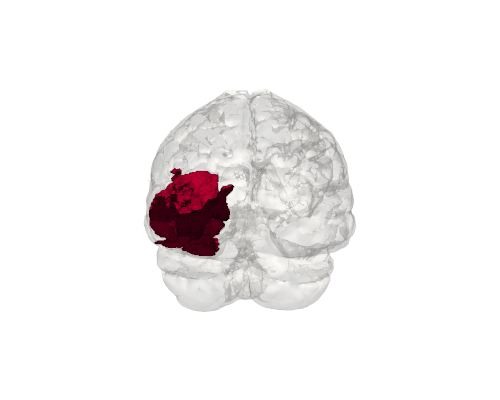

In [6]:
base_path = "PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5/UCSF-PDGM-0032_nifti/"

mri_filename = "UCSF-PDGM-0032_FLAIR_bias.nii.gz"
mri_filepath = os.path.join(base_path, mri_filename)

tumor_mask_filename = "UCSF-PDGM-0032_tumor_segmentation.nii.gz"
tumor_mask_filepath = os.path.join(base_path, tumor_mask_filename)

mri_img = nib.load(mri_filepath)
mri_data = mri_img.get_fdata()

tumor_mask_img = nib.load(tumor_mask_filepath)
tumor_mask_data = tumor_mask_img.get_fdata()

mri_grid = pv.wrap(mri_data)
tumor_grid = pv.wrap(tumor_mask_data)


brain_surface = mri_grid.contour([300]).smooth(n_iter=50, relaxation_factor=0.1)
tumor_surface = tumor_grid.contour([0.5]).smooth(n_iter=30)

plotter = pv.Plotter(off_screen=True, window_size=[500, 400])

plotter.add_mesh(brain_surface, color="white", opacity=0.2, specular=0.3, specular_power=10)
plotter.add_mesh(tumor_surface, color="#c70039", opacity=1.0)
plotter.enable_shadows()

plotter.camera_position = 'iso'

output_filename = "brain_tumor_3rd_person_view.gif"

path = plotter.generate_orbital_path(n_points=72)
plotter.open_gif(output_filename)
plotter.orbit_on_path(path, write_frames=True)
plotter.close()

display(Image(filename=output_filename))

## 📑 Split Dataset into Train, Validation, and Test Sets

We split the data into:
- **Training set** → 70% of the data
- **Validation set** → 15% of the data
- **Test set** → 15% of the data

The `stratify` parameter ensures that the **class distribution** of `IDH_binary` remains consistent across all subsets.  
A fixed `random_state=42` is used for **reproducibility**.


In [7]:
train_df, temp_df = train_test_split(final_df, test_size = 0.3, random_state=42, stratify=final_df['IDH_binary'])

val_df, test_df = train_test_split(temp_df, test_size = 0.5, random_state=42, stratify=temp_df['IDH_binary'])

## 🔍 Inspect Individual MRI Scan Files

This function inspects a single patient’s MRI scan by:  
- Verifying the file exists at the specified path  
- Loading the image using **SimpleITK**  
- Printing out the original **image dimensions (voxels)** and **voxel spacing (mm)**  

We then define the paths for a sample patient’s core MRI sequences and tumor segmentation files and run the inspection to confirm data integrity and metadata consistency.

In [8]:
def inspect_single_mri_scan(patient_folder_path, mri_filename):
    
    full_mri_path = os.path.join(patient_folder_path, mri_filename)

    print(f"--- Inspecting File: {full_mri_path} ---")

    if not os.path.exists(full_mri_path):
        print(f"Error: File not found at the specified path.")
        return

    try:
        image = sitk.ReadImage(full_mri_path)
        print("Successfully loaded the image.")
    except Exception as e:
        print(f"An error occurred while trying to read the file: {e}")
        return


    size = image.GetSize()
    print(f"Original Size (in voxels): {size}")

    spacing = image.GetSpacing()
    print(f"Original Spacing (in mm): {spacing}")
    
    print("-------------------------------------------\n")


base_data_directory = "PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5"


patient_folder_name = "UCSF-PDGM-0520_nifti"

patient_id = patient_folder_name.replace("_nifti", "")

patient_folder_path = os.path.join(base_data_directory, patient_folder_name)

core_files = [
    f"{patient_id}_t1.nii.gz",
    f"{patient_id}_t1c.nii.gz",
    f"{patient_id}_t2.nii.gz",
    f"{patient_id}_flair.nii.gz",
    f"{patient_id}_tumor_segmentation.nii.gz"
]

if not os.path.isdir(patient_folder_path):
        print(f"Error: The patient folder was not found at: {patient_folder_path}")
        print("Please check the 'base_data_directory' and 'patient_folder_name' variables.")
else:
    for filename in core_files:
        inspect_single_mri_scan(patient_folder_path, filename)


--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_t1.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)
Original Spacing (in mm): (1.0, 1.0, 1.0)
-------------------------------------------

--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_t1c.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)
Original Spacing (in mm): (1.0, 1.0, 1.0)
-------------------------------------------

--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_t2.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)
Original Spacing (in mm): (1.0, 1.0, 1.0)
-------------------------------------------

--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_flair.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)

## 🔄 Resample MRI Images to Target Size

This function resamples an input SimpleITK image to a fixed spatial resolution and size (`target_size`).  
- Adjusts the voxel spacing proportionally to preserve the physical dimensions.  
- Uses **linear interpolation** for MRI scans and **nearest neighbor** for segmentation masks to avoid label mixing.  
- Returns the resampled image as a NumPy array for further processing and model input.


In [9]:
def resample_image(image, target_size = (224,224,128), is_segmentation=False):

    original_size = image.GetSize()
    original_spacing = image.GetSpacing()

    new_spacing = [
        original_spacing[0] * (original_size[0] / target_size[0]),
        original_spacing[1] * (original_size[1] / target_size[1]),
        original_spacing[2] * (original_size[2] / target_size[2])
    ]

    interpolator = sitk.sitkLinear
    if is_segmentation:
        interpolator = sitk.sitkNearestNeighbor

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(target_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(interpolator)

    resampled_image = resampler.Execute(image)

    image_array = sitk.GetArrayFromImage(resampled_image)

    return image_array

## 📦 Custom Dataset Class and Data Augmentation Pipeline

- **`UCSFDataset`**: A PyTorch `Dataset` subclass to load and preprocess multi-modal MRI scans for each patient.  
  - Reads multiple MRI modalities (`FLAIR_bias`, `T1c_bias`, `T2_bias`, `T1_bias`) per subject.  
  - Resamples images to a fixed size `(224, 224, 128)` and stacks them as input channels.  
  - Retrieves corresponding binary IDH mutation labels.  
  - Supports optional data transformations for augmentation and normalization.

- **Data Transforms** (using `torchio`):  
  - `train_transform`: normalization, random flipping (left-right), and affine transformations for data augmentation.  
  - `test_transform`: only normalization, to keep evaluation consistent.

- **Dataset Instances**: Created for training, validation, and testing subsets with appropriate transforms.

- **Handling Class Imbalance**:  
  - Calculates inverse-frequency weights for each class.  
  - Uses `WeightedRandomSampler` to ensure balanced sampling during training.

- **DataLoaders**:  
  - `trainLoader` uses the weighted sampler with shuffling enabled.  
  - `testLoader` and `valLoader` are standard loaders without sampling weights.


In [10]:
class UCSFDataset(Dataset):
    def __init__(self, root_dir, labels_df, modalities, transform=None):
        self.root_dir = root_dir
        self.labels_df = labels_df
        self.modalities = modalities
        self.transform = transform
        self.subject_ids = labels_df['ID'].tolist()

    def __len__(self):
        return len(self.subject_ids)

    def __getitem__(self, idx):
        subject_id = self.subject_ids[idx]
        prefix, number_and_suffix = subject_id.rsplit('-', 1)
        if '_' in number_and_suffix:
            number_str, suffix = number_and_suffix.split('_', 1)
            suffix = f"_{suffix}"
        else:
            number_str = number_and_suffix
            suffix = ""
        number = int(number_str)
        subject_folder = f"{prefix}-{number:04}{suffix}_nifti"
        filename_base = f"{prefix}-{number:04}{suffix}"
        specific_row = self.labels_df[self.labels_df["ID"] == subject_id]
        if not specific_row.empty:
            label = specific_row["IDH_binary"].values[0]
            input_modalities = []
            for modality in self.modalities:
                filename = f"{filename_base}_{modality}.nii.gz"
                filepath = os.path.join(self.root_dir, subject_folder, filename)
                image = sitk.ReadImage(filepath)
                resampledImage = resample_image(image, (128,128,128))
                input_modalities.append(resampledImage)
            stacked_images = np.stack(input_modalities, axis = 0)
            image_tensor = torch.from_numpy(stacked_images).float()
            label_tensor = torch.tensor(label, dtype=torch.long)
            if self.transform:
                final_image_tensor = self.transform(image_tensor)
                return final_image_tensor, label_tensor
            
            return image_tensor, label_tensor
        else:
            print(subject_id)
            return self[idx + 1]


test_transform = tio.Compose([
    tio.ZNormalization(),
])

train_transform = tio.Compose([
    tio.ZNormalization(),
    tio.RandomFlip(axes=('LR',), flip_probability=0.5),
    tio.RandomAffine(
        scales=(0.95, 1.05),
        degrees=5,
        isotropic=False,
    ),
    tio.RandomBiasField(p=0.3),
    tio.RandomGamma(
        log_gamma=(np.log(0.9), np.log(1.1)),
        p=0.3,
    ),
])


modalities = ["FLAIR_bias",
              "T1_bias",
              "T1c_bias",
              "T2_bias"
              ]
if __name__ == '__main__':
    trainDataset = UCSFDataset("PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5", train_df, modalities, train_transform)
    testDataset = UCSFDataset("PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5", test_df, modalities, test_transform)
    valDataset = UCSFDataset("PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5", val_df, modalities, test_transform)

    labels = []

    for i in range(len(trainDataset)):
        _, label_tensor = trainDataset[i]
        labels.append(label_tensor.item())

    class_counts = Counter(labels)
    class_weights = {cls:1.0/count for cls, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in labels]
    sample_weights = torch.DoubleTensor(sample_weights)
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


    trainLoader = DataLoader(trainDataset, batch_size=4, sampler=sampler, pin_memory=True)
    testLoader = DataLoader(testDataset, batch_size=4, pin_memory=True)
    valLoader = DataLoader(valDataset, batch_size=4, pin_memory=True)

## 🧠 MRI Loading, Normalization & Augmentation (3D Visualization)

This cell:
1. Loads an MRI scan (`nibabel`).
2. Normalizes intensities (`TorchIO` ZNormalization).
3. Applies random augmentations twice (`train_transform`).
4. Creates 3D surface renderings with PyVista.
5. Displays original vs augmented versions side by side.


Loading file: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5/UCSF-PDGM-0004_nifti/UCSF-PDGM-0004_FLAIR_bias.nii.gz...
File loaded successfully.
Applying random augmentations...
Generating 3D surface renderings...
Displaying results...


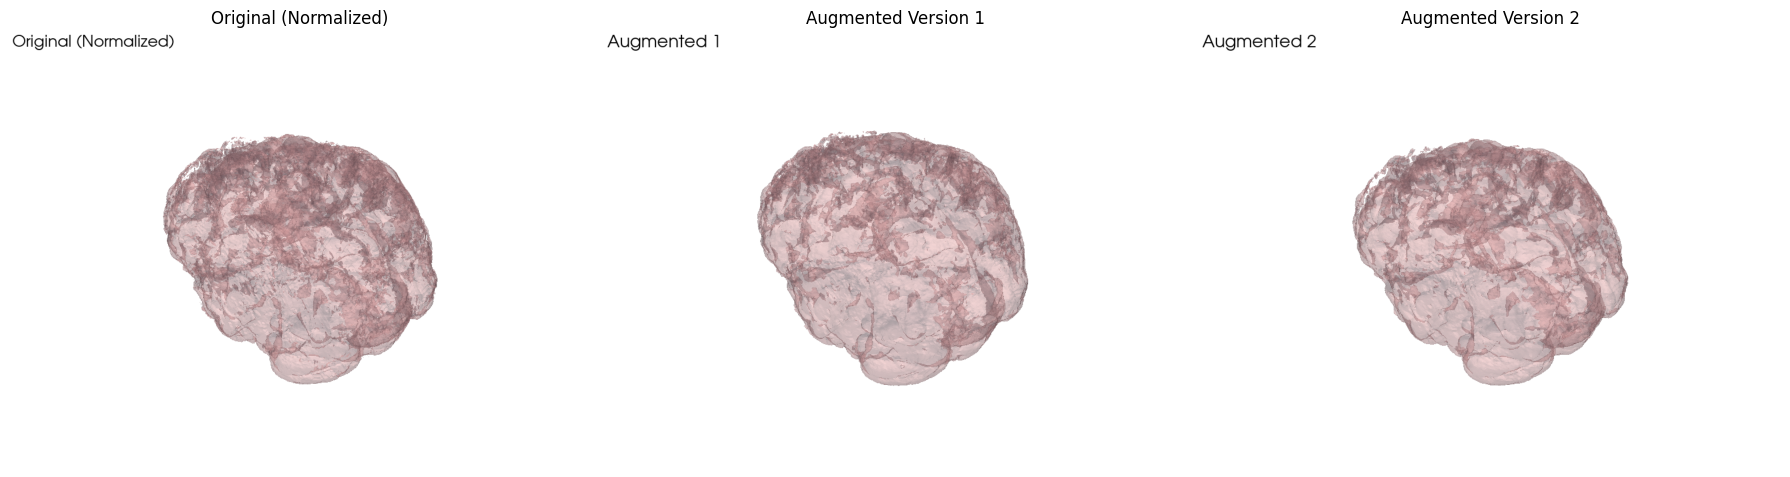

In [11]:
file_path = "PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5/UCSF-PDGM-0004_nifti/UCSF-PDGM-0004_FLAIR_bias.nii.gz"

try:
    print(f"Loading file: {file_path}...")
    mri_img = nib.load(file_path)
    original_np = mri_img.get_fdata()
    print("File loaded successfully.")

    original_tensor = torch.from_numpy(original_np).unsqueeze(0).float()
    original_subject = tio.Subject(mri=tio.ScalarImage(tensor=original_tensor))

    normalizer = tio.ZNormalization()
    normalized_original_subject = normalizer(original_subject)
    original_np_normalized = normalized_original_subject.mri.data[0].cpu().numpy()


    print("Applying random augmentations...")
    augmented_subject_1 = train_transform(original_subject)
    augmented_subject_2 = train_transform(original_subject)

    aug1_np = augmented_subject_1.mri.data[0].cpu().numpy()
    aug2_np = augmented_subject_2.mri.data[0].cpu().numpy()

    def visualize_surface(volume_np, title="Surface"):
        """Creates a static 3D surface plot of a NumPy volume."""
        grid = pv.ImageData()
        grid.dimensions = volume_np.shape
        grid.point_data["values"] = volume_np.flatten(order="F")

        surface_mesh = grid.contour(isosurfaces=[0.5])

        plotter = pv.Plotter(off_screen=True)
        plotter.add_mesh(surface_mesh, color='pink', opacity=0.3)
        plotter.add_text(title, font_size=12)
        plotter.view_isometric()
        return plotter.screenshot()

    print("Generating 3D surface renderings...")
    original_plot = visualize_surface(original_np_normalized, title="Original (Normalized)")
    aug1_plot = visualize_surface(aug1_np, title="Augmented 1")
    aug2_plot = visualize_surface(aug2_np, title="Augmented 2")


    print("Displaying results...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(original_plot)
    axes[0].set_title("Original (Normalized)")
    axes[0].axis('off')

    axes[1].imshow(aug1_plot)
    axes[1].set_title("Augmented Version 1")
    axes[1].axis('off')

    axes[2].imshow(aug2_plot)
    axes[2].set_title("Augmented Version 2")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"ERROR: The file was not found. Please check the path:\n{file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

In [12]:
model = resnet34(spatial_dims=3,
                 n_input_channels=4
                )
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model is ready on {device}!")

Model is ready on cuda!


In [13]:
loaded = torch.load("resnet_34_23dataset.pth")

print("Weights loaded successfully!")

Weights loaded successfully!


In [14]:
weights_dic = {}

for key, value in loaded["state_dict"].items():
        new_key = key[7:]
        weights_dic[new_key] = value

new_dic = {}

for key, value in weights_dic.items():
    if value.shape == model.state_dict()[key].shape:
        new_dic[key] = value
    
model.load_state_dict(new_dic, strict=False)

for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.layer4.parameters():
    parameter.requires_grad = True
    
for parameter in model.fc.parameters():
    parameter.requires_grad = True

for parameter in model.conv1.parameters():
    parameter.requires_grad = True

torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv3d: 1-1                            87,808
├─BatchNorm3d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool3d: 1-4                         --
├─Sequential: 1-5                        --
│    └─ResNetBlock: 2-1                  --
│    │    └─Conv3d: 3-1                  (110,592)
│    │    └─BatchNorm3d: 3-2             (128)
│    │    └─ReLU: 3-3                    --
│    │    └─Conv3d: 3-4                  (110,592)
│    │    └─BatchNorm3d: 3-5             (128)
│    └─ResNetBlock: 2-2                  --
│    │    └─Conv3d: 3-6                  (110,592)
│    │    └─BatchNorm3d: 3-7             (128)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv3d: 3-9                  (110,592)
│    │    └─BatchNorm3d: 3-10            (128)
│    └─ResNetBlock: 2-3                  --
│    │    └─Conv3d: 3-11                 (110,592)
│    │    └─Batch

In [15]:
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    class_counts = final_df['IDH_binary'].value_counts().sort_index()
    total_samples = len(final_df)
    n_classes = len(class_counts)
    class_weights = total_samples / (n_classes * class_counts)
    class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params_to_update, lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_path='best_model.pth', checkpoint_path='training_checkpoint.pth'):
    
    
    best_val_loss = float('inf') 
    start_epoch = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    if os.path.exists(checkpoint_path):
        print(f"Resuming training from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']
        best_val_loss = checkpoint['best_val_loss']
        print(f"Resuming from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
                
            running_loss = 0.0
            running_corrects = 0 


            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    

                    _, preds = torch.max(outputs, 1) 
                    
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0) 

                running_corrects += torch.sum(preds == labels.data) 

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset) 

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                old_lr = optimizer.param_groups[0]['lr']
                scheduler.step(epoch_loss)
                new_lr = optimizer.param_groups[0]['lr']
                
                if new_lr < old_lr:
                    print(f"Learning rate reduced from {old_lr} to {new_lr}")
                
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    torch.save(model.state_dict(),model_path)
                    print(f'Best model saved to {model_path}')
                    
            print("Saving checkpoint...")
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'history': history,
                'best_val_loss': best_val_loss
            }
            torch.save(checkpoint, checkpoint_path)

    print('Training complete!')
    return model, history

In [17]:
trained_model, training_history = train_model(
    model, 
    trainLoader, 
    valLoader, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=30
)

Epoch 1/1
------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [36:02<00:00, 24.57s/it]


train Loss: 0.6009 Acc: 0.5457


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [02:34<00:00,  8.11s/it]


val Loss: 1.1756 Acc: 0.2000
Best model saved to best_model.pth
Training complete!


In [18]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate_model(model,testLoader,model_path='best_model.pth',device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(testLoader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _,preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())            
            
    accuracy = accuracy_score(all_labels,all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    print(f"\n--- Test Set Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("--------------------------\n")

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Pink',
                xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
                yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    metrics = {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }
    return metrics

In [19]:
model_to_evaluate = resnet34(spatial_dims=3,
                             n_input_channels=4
                            )
model_to_evaluate.fc = nn.Linear(in_features=model_to_evaluate.fc.in_features, out_features=2)
test_metrics = evaluate_model(model_to_evaluate, testLoader)
print(test_metrics)

Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 19/19 [02:35<00:00,  8.16s/it]



--- Test Set Performance ---
Accuracy: 0.2105
F1 Score: 0.0732
--------------------------



KeyError: "'Pinks' is not a known colormap name"

<Figure size 1500x1200 with 0 Axes>